## to add
- ~~look at frequencies found around peak volume (more than just two, see what optimal number is)
- ~~remove points at the two ends of the spectrum, they are not going to be right at the peak
    - this will reduce the number of false peaks found, and we can get the two tallest peaks
    - then take the difference in frequency between the two tallest peaks (and maybe the height percentage)
    - this should add infromation that just the peak location will not provide
- top two frequencies from each specrtum
- check the power in each frequency-band
- if same birds keep getting mis-identified (due to similar frequencies) just classify them into a single group
- apply filter to groups
    -determine filter level based on whether the background frequency up to a certain band is there for the entire signal!!!!
- cast the signal into a different sample rate, see if it gets better/differnt results
- maybe use flatness locator from librosa


if same binning for the differnt transform types (i.e. the 'loudest point')
- extract the different features from each of the spectra at that bin location
- Q: to use all of the cepstral coefficients? or just the 'most important'?
    - how to know what the most important cepstralcoefficients are?
    

librosa produces 320 bins by defaults (this depends of sample rate?) (44100) -> (125)
48000 -> (136 bins)

- peak spacing in rms peaks
- get prominent frequency for torch mel spectrogram
- distance between volume peaks in mrel spec
- number of peaks in rms spcrum?

turn off ~~smart~~ *dumb* complete

In [ ]:
#I want a manual transmission, not an automatic...
# Run this in Python once, it should take effect permanently (change to False to None to revert)
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

all about birds suggests that most cals are betweem 1000 and 8000 Hz
- filter out calls below 400 Hz to start, and see what the effect is.
- in mel freq filter below 500 Hz
achieve the filtering by setting all rows lower than a certain value to zero in the stft array

In [31]:
import os
cwd = os.getcwd()
path =  os.path.join( cwd, '../examples/cutclips' )
files = [f for f in os.listdir( path )]

n = 8510
file = files[n]
filename = os.path.join( path, file )
#filename = '/home/chris/Documents/Insight2020/examples/cutclips/Scarlet Tanager_2_0.wav' #temp ovveride for pres
#filename = 'Scarlet Tanager_2_0.wav'
filename

'/home/chris/Documents/Insight2020/birdsounder-model/../examples/cutclips/Grey Catbird_100_8.wav'

In [32]:
fileIwant = [(i,f) for i,f in enumerate(files) if f=='Scarlet Tanager_2_0.wav']
fileIwant

[(56426, 'Scarlet Tanager_2_0.wav')]

In [33]:
import torchaudio
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences
import librosa
import librosa.display


In [34]:
def Normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

In [35]:
#load the file, create a numpy array version so librosa can process it
filepath = os.path.join( path, filename )
wf, sr = torchaudio.load( filepath )
#wf_rs = torchaudio.transforms.Resample( orig_freq=16000, new_freq=8000 )(wf)
wf_np = np.asfortranarray( wf[0].numpy() )
spectrogram = torchaudio.transforms.Spectrogram()( wf )
yn = Normalize( wf )
y = np.asfortranarray( yn[0].numpy() ) #wf[0].numpy() )

#cpmpute the spectrograms of the data
S, phase = librosa.magphase(librosa.stft(wf_np))
Sn, phase = librosa.magphase(librosa.stft(y))

yn.shape, y.shape, type( y ), sr

(torch.Size([1, 63945]), (63945,), numpy.ndarray, 44100)

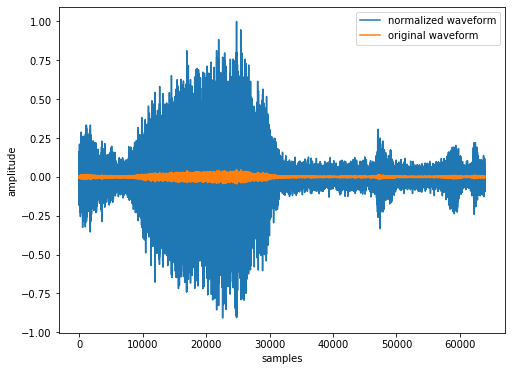

In [36]:
#plot the original spectrum, and the normalized version
f,ax = plt.subplots( figsize=(8,6) )
ax.plot( y, alpha=1.0, label='normalized waveform' );
ax.plot( wf_np, alpha=1.0, label='original waveform' );
#ax.plot( np.asfortranarray( wf_rs[0].numpy() ), alpha=0.6, label='original wf' );

#ax.plot( yr, alpha=0.6, label='recronstructed wf' );
ax.set_xlabel('samples')
ax.set_ylabel('amplitude')
ax.legend()

In [37]:
def FindPeaks(x, ax, height=0.6, output=True):
    peaks, _ = find_peaks(x, height=height*max(x), distance=5, width=3 )
    prominences = peak_prominences(x, peaks)[0]
    contour_heights = x[peaks] - prominences
    ax.plot(peaks, x[peaks], "x")
    ax.vlines(x=peaks, ymin=contour_heights, ymax=x[peaks])
    #end peak finding
    #...just use max for now
    print(peaks, x[peaks])
    peak_order = sorted( zip( peaks, x[peaks] ), key=lambda l: l[1], reverse=True) 
    print(peak_order)#, x[ list(peak_order[0,:]) ])
    
    #plt.show()
    return peak_order #peaks, x[peaks]

In [38]:
def GetRMS(y):
    '''takes numpy array of normalized original sample'''
    rms = librosa.feature.rms(y=y)
    return rms.min(), rms.max(), rms.mean(), rms.std()

def GetFlatness( y ):
    '''same for normalized and non-normalized sample'''
    flatness = librosa.feature.spectral_flatness(y=y)
    return flatness.min(), flatness.max(), flatness.mean(), flatness.std()

def GetRolloff( y, sr ):
    '''normalized or non-normalzied give same results'''
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    return rolloff.min(), rolloff.max(), rolloff.mean(), rolloff.std()

def GetContrast( y, sr ):
    '''takes normalized sample (maybe normalized???)
    returns min, max, mean, std'''
    contrasts = librosa.feature.spectral_contrast(y=y, sr=sr)
    mins = [l.min() for l in contrasts]
    maxs = [l.max() for l in contrasts]
    means = [l.mean() for l in contrasts]
    stds = [l.std() for l in contrasts]
    #ranks = sorted( zip( range(7), contrasts.sum(1), mins, maxs, means, stds ), key=lambda l:l[1], reverse=True)
    ls = sorted( zip( range(7), contrasts.sum(1) ), key=lambda l:l[1], reverse=True)
    vals = list( zip( mins, maxs, means, stds ) )
    ranks = [l[0] for l in ls]
    return ranks, vals

[ 12  44  54  74 105] [5654.85085445 4682.70707564 4749.9547656  5898.93202289 6366.73148859]
[(105, 6366.731488585469), (74, 5898.932022894931), (12, 5654.850854445195), (54, 4749.954765596069), (44, 4682.707075639368)]
rms min 4441.626496637132, max 6363.433935381208, mean 5227.7956990048815 std 533.1195566832807
rms min 4442.270487690383, max 6366.731488585469, mean 5230.981311551838 std 535.0000092875715


[(105, 6366.731488585469),
 (74, 5898.932022894931),
 (12, 5654.850854445195),
 (54, 4749.954765596069),
 (44, 4682.707075639368)]

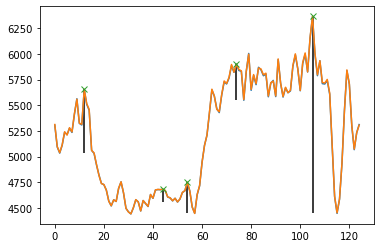

In [41]:
cent = librosa.feature.spectral_centroid( wf_np, sr )
centN = librosa.feature.spectral_centroid( y, sr )

f,ax = plt.subplots()
ax.plot( cent[0], label='wf_np' )
ax.plot( centN[0], label='y (normalized)' )

pks = FindPeaks( centN[0], ax=ax )

print( f'rms min {cent.min()}, max {cent.max()}, mean {cent.mean()} std {cent.std()}')
print( f'rms min {centN.min()}, max {centN.max()}, mean {centN.mean()} std {centN.std()}')
pks

[35 47] [0.286916   0.33343154]
[(47, 0.33343154), (35, 0.286916)]


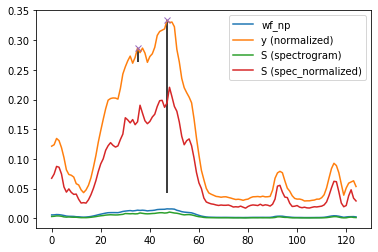

rms shape (1, 125)
rms min 0.0014159370912238955, max 0.01608916185796261, mean 0.005706441588699818 std 0.0047381860204041
rms min 0.029323499649763107, max 0.33343154191970825, mean 0.1182556003332138 std 0.09819614142179489


(0.0293235, 0.33343154, 0.1182556, 0.09819614)

In [42]:


rms = librosa.feature.rms(y=wf_np)
rmsN = librosa.feature.rms(y=y)
rmsS = librosa.feature.rms(S=S)
rmsSn = librosa.feature.rms(S=Sn)

f,ax = plt.subplots()
ax.plot( rms[0], label='wf_np' )
ax.plot( rmsN[0], label='y (normalized)' )
ax.plot( rmsS[0], label='S (spectrogram)' )
ax.plot( rmsSn[0],  label='S (spec_normalized)')
ax.legend()

FindPeaks( rmsN[0], ax=ax )
#FindPeaks( rmsN[0], ax=ax )
plt.show()

print('rms shape', rms.shape )
print( f'rms min {rms.min()}, max {rms.max()}, mean {rms.mean()} std {rms.std()}')
print( f'rms min {rmsN.min()}, max {rmsN.max()}, mean {rmsN.mean()} std {rmsN.std()}')

#np.average( rms ), np.average( rmsN ), np.average( rmsS ), np.average( rmsSn )
GetRMS( y )

In [5]:


flatness = librosa.feature.spectral_flatness(y=wf_np)
flatnessN = librosa.feature.spectral_flatness(y=y)
flatnessS = librosa.feature.spectral_flatness(S=S)
flatnessSn = librosa.feature.spectral_flatness(S=Sn)

f,ax = plt.subplots()
ax.plot( flatness[0], label='wf_np' )
ax.plot( flatnessN[0], label='y (normalized)' )
ax.plot( flatnessS[0], label='S (spectrogram)' )
ax.plot( flatnessSn[0],  label='S (spec_normalized)')
ax.legend()
plt.show()

print( f'rms min {flatnessN.min()}, max {flatnessN.max()}, mean {flatnessN.mean()} std {flatnessN.std()}')

#np.average( flatness ), np.average( flatnessN ), np.average( flatnessS ), np.average( flatnessSn )
#same for norm and non-norm versions
GetFlatness( y )

NameError: name 'wf_np' is not defined

In [6]:


rolloff = librosa.feature.spectral_rolloff(y=wf_np, sr=sr)
rolloffN = librosa.feature.spectral_rolloff(y=y, sr=sr)
rolloffS = librosa.feature.spectral_rolloff(S=S, sr=sr)
rolloffSn = librosa.feature.spectral_rolloff(S=Sn, sr=sr)

f,ax = plt.subplots()
ax.plot( rolloff[0], label='wf_np' )
ax.plot( rolloffN[0], label='y (normalized)' )
ax.plot( rolloffS[0], label='S (spectrogram)' )
ax.plot( rolloffSn[0],  label='S (spec_normalized)')
ax.legend()
plt.show()

print( f'rms min {rolloff.min()}, max {rolloff.max()}, \
mean {rolloff.mean()} std {rolloff.std()}')


#np.average( rolloff ), np.average( rolloffN ), np.average( rolloffS ), np.average( rolloffSn )
GetRolloff( y, sr )

NameError: name 'wf_np' is not defined

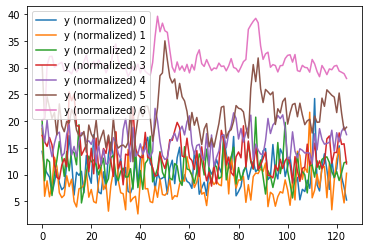

([6, 5, 4, 3, 2, 0, 1],
 (20.155182541788157,
  39.60249847957727,
  30.870273823875415,
  2.756140047560708),
 (12.400626788020615,
  35.002319848799594,
  21.124948641500495,
  4.126124891002746))

In [45]:


spec_contrast = librosa.feature.spectral_contrast( wf_np, sr )
spec_contrastN = librosa.feature.spectral_contrast( y, sr )
spec_contrastS = librosa.feature.spectral_contrast( S=S, sr=sr )
spec_contrastSn = librosa.feature.spectral_contrast( S=Sn, sr=sr )


f,ax = plt.subplots()
#ax.plot( spec_contrast[0], label='wf_np' )
for i in range(7):
    ax.plot( spec_contrast[i], label=f'y (normalized) {i}' )
#ax.plot( spec_contrastS[0], label='S (spectrogram)' )
#ax.plot( spec_contrastSn[0],  label='S (spec_normalized)')
ax.legend()
plt.show()
'''
for spec_contrast in spec_contrasts:
    print( f'rms min {spec_contrast.min()}, max {spec_contrast.max()}, \
    mean {spec_contrast.mean()} std {spec_contrast.std()}')
print( f'rms min {spec_contrastN.min()}, max {spec_contrastN.max()}, \
mean {spec_contrastN.mean()} std {spec_contrastN.std()}')
'''
#np.average( spec_contrast ), np.average( spec_contrastN ), np.average( spec_contrastS ), np.average( spec_contrastSn )
#same for norm and non-norm versions
ls, vals = GetContrast(wf_np, sr)#, spec_contrast.shape
#np.array(ls[0][2]).mean(), np.array(ls[1][2]).mean(), np.array(ls[2][2]).mean()
#ls[::1]
ls, vals[6], vals[5]

In [ ]:
ls = sorted( zip( range(7), spec_contrasts.sum(1), spec_contrasts ), key=lambda l:l[1], reverse=True)
avgs = [np.average(l[2]) for l in ls]
rank, avgs

In [ ]:
cepstral = librosa.feature.mfcc(y, sr)

for i in range(20):
    plt.plot(cepstral[i], label=i)
plt.legend()
    
plt.show()    
librosa.display.specshow(cepstral, y_axis='mel', x_axis='frames');#,x_axis='time'
plt.show()

cepstral.shape, np.average(cepstral[0]), np.average(cepstral[1]), np.average(cepstral[2])

In [ ]:
mfcc = torchaudio.transforms.MFCC( sample_rate=sr)(wf)


mfcc_np = mfcc.detach().numpy()[0]
librosa.display.specshow(mfcc_np, y_axis='mel', x_axis='frames');#,x_axis='time'
plt.show()
librosa.display.specshow(mfcc_np[:,:1], sr=sr, y_axis='mel', x_axis='frames');
plt.show()
mfcc.shape, type(mfcc), mfcc_np.shape, mfcc_np[:,:1]


In [ ]:
from matplotlib.colors import LogNorm
import pandas as pd

mel_specgram = torchaudio.transforms.MelSpectrogram(sr)(yn)#(wf)
#plt.imshow( mel_specgram.detach().numpy()[0], norm=LogNorm() )

mel_np = mel_specgram.detach().numpy()[0]
mel_db = librosa.core.amplitude_to_db( mel_np )
librosa.display.specshow(mel_np, y_axis='mel', x_axis='frames', )#,x_axis='time'
plt.colorbar()
plt.show()

plt.figure()#figsize=(10,8))
librosa.display.specshow(mel_db, y_axis='mel', x_axis='frames', )#,x_axis='time'
plt.title('Mel-frequencty Spectrogram')
plt.colorbar(format='%+2.0f dB')
amp, freq = mel_np.sum(0), mel_np.sum(1)
plt.show()
plt.figure()
#ax = plt.subplot(2,1,1)
plt.plot(amp, '.-', label='sum of amplitudes')
plt.figure()
#ax = plt.subplot(2,1,2)
f,ax = plt.subplots()
ax.set_title('sum along frequency axis')
ax.plot(freq, '.-', label='sum of frequencies')
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('occurrences')
plt.legend()
plt.show()
#hdata = list(zip( range(len(amp)), amp ))

plt.bar( range(len(amp)), amp )
plt.show()
plt.bar( range(len(freq)), freq )
mel_specgram.shape

In [ ]:
spec_np = spectrogram.detach().numpy()[0]
librosa.display.specshow(spec_np, y_axis='log', x_axis='frames')#,x_axis='time'
plt.show()
spec_np

background filtering using mel-spectrogram

In [ ]:
p0 = librosa.feature.poly_features(S=S, sr=sr, order=0)
p1 = librosa.feature.poly_features(S=S, sr=sr, order=1)
p2 = librosa.feature.poly_features(S=S, sr=sr, order=2)

p0n = librosa.feature.poly_features(S=Sn, sr=sr, order=0)
p1n = librosa.feature.poly_features(S=Sn, sr=sr, order=1)
p2n = librosa.feature.poly_features(S=Sn, sr=sr, order=2)

f,ax = plt.subplots()
plt.plot( p0[0], label='p0' )
plt.plot( p1[1], label='p1'  )
plt.plot( p2[2], label='p2'  )
plt.plot( p0n[0], label='p0n' )
plt.plot( p1n[1], label='p1n'  )
plt.plot( p2n[2], label='p2n'  )
ax.legend()

x = p0[0]
peaks, _ = find_peaks(x, height=0.4*max(x), distance=10) #, prominence=5
print('peak list', peaks)
prominences = peak_prominences(x, peaks)[0]
contour_heights = x[peaks] - prominences
plt.plot( peaks, x[peaks], "x")
plt.vlines(x=peaks, ymin=contour_heights, ymax=x[peaks])

FindPeaks(x=p0[0], ax=ax)

In [9]:
# We recommend scaling y to the range [-2**31, 2**31[ before applying
# PCEN's default parameters. Furthermore, we use power=1 to get a
# magnitude spectrum instead of a power spectrum.

#y = wf_np
def MelSpectrogramFiltering(y, sr):
    M = librosa.feature.melspectrogram(y, sr=sr, power=1)
    print('M shape', M.shape)
    log_M = librosa.amplitude_to_db(M, ref=np.max)
    pcen_M = librosa.pcen(M * (2**31))
    plt.figure( figsize=(14,10))
    plt.subplot(2,1,1)
    librosa.display.specshow(log_M[:, 20:], x_axis='time', y_axis='mel')
    plt.title('log amplitude (dB)')
    plt.colorbar()
    plt.subplot(2,1,2)
    librosa.display.specshow(pcen_M[:, 20:], x_axis='time', y_axis='mel')
    plt.title('Per-channel energy normalization')
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    #plt.plot( pcen_M[:, 20:].sum(1) )
    plt.plot( M[:,:].sum(1), label='original_M' )
    
    plt.plot( pcen_M[:,:].sum(1), label='pcen_M' )
    pcen_M[:, 20:] = 0
    plt.plot( pcen_M[:,:].sum(1), label='pcen_M first 20 cut' )
    plt.legend()
    M.shape
    return M

M = MelSpectrogramFiltering(y, sr)

NameError: name 'y' is not defined

In [ ]:
def Reconstruct(M, sr):
    #reconstruct the stft from the mel-spectrogram
    Sr = librosa.feature.inverse.mel_to_stft(M, sr)
    #reconstruct the original signal
    yr = librosa.griffinlim(Sr) #griffin transformation
    #yr = librosa.istft(Sr, hop_length=512)
    plt.figure()
    plt.subplot(3,1,1)
    librosa.display.specshow(Sr, x_axis='time', y_axis='log')
    plt.title('Reconstructed stft (dB)')
    plt.colorbar()
    #librosa.display.specshow(log_M, x_axis='time', y_axis='log')
    plt.subplot(3,1,2)
    #plt.plot( yr )
    plt.plot( Sr.sum(1) )
    plt.title('reconstructed audio')
    plt.colorbar()
    
    yr.shape, type( yr )
    plt.subplot(3,1,3)
    plt.plot(yr)
    plt.show()
    return yr
    
yr = Reconstruct(M, sr)

In [ ]:
def MelFilterCompare( M, pcen_M ):
    pcen_max = librosa.pcen(M * (2**31), max_size=3)
    plt.figure()
    plt.subplot(2,1,1)
    librosa.display.specshow(pcen_M, x_axis='time', y_axis='mel')
    plt.title('Per-channel energy normalization (no max-filter)')
    plt.colorbar()
    plt.subplot(2,1,2)
    librosa.display.specshow(pcen_max, x_axis='time', y_axis='mel')
    plt.title('Per-channel energy normalization (max_size=3)')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

define a low frequency filter (high-pass)
- can also be used as a band-pass filter if a lowerfreq is also supplied as an argument

In [4]:

def ApplyFilter( Din, sr, upperfreq = 1020, lowerfreq=None ):
    '''high pass filter
    ci = 250 #~5000, ci = 125 #~2691, ci = 50 #~1000, ci = 40'''
    frequency_conversion = librosa.core.fft_frequencies(sr=sr)
    upper_index = np.abs(frequency_conversion - upperfreq).argmin()
    #print(f'upper frequency index, {upper_index} closest freq {frequency_conversion[upper_index]}')
    if lowerfreq is not None:
        lower_index = np.abs(frequency_conversion - lowerfreq).argmin()
        #print(f'lower frequency index, {lower_index} closest freq {frequency_conversion[lower_index]}')
    else:
        lower_index = 0
    Din[lower_index:upper_index,:] = np.zeros( (upper_index-lower_index, Din.shape[1]) )
    

In [ ]:
import os
os.getcwd()

#find the peak, cut two seconds and store in a new array temporarily...
#or if longer recording,take all of the peak samples, or the biggest 2, or 3, and get the most likely for all
#draw colored boxes around sample sections in the app interface

In [5]:
    
#function to get frequency bin with most entries (i.e. the Prominent Frequency)
def GetPromFreqIndex(y, sr, filt_Hz, output=False):
    
    #hop_length = 512
    D = np.abs(librosa.stft(y))
    #print('shape', D.shape)
    nc = 20
    D[:,:nc], D[:,-nc:] = 0, 0
    ####following lines are for testing
    
    if filt_Hz is not None:
        ApplyFilter(D, sr, filt_Hz)
    
    ####end testing lines, remove once completed, make a more succinct function
    freq_sum =  D.sum(1)
    
    #get the most prominent frequency index
    prom_freq = freq_sum.tolist().index(max(freq_sum))
    
    if output:
        print('filter frequency', filt_Hz)
        print('sr', sr)
        #times = librosa.times_like(D)
        plt.figure( figsize=(8,6))
        ax1 = plt.subplot(2, 1, 1)
        dbs = librosa.amplitude_to_db(D, ref=np.max)
        librosa.display.specshow(dbs, sr=sr, y_axis='log', x_axis='time')
        plt.title('Power spectrogram')
        #ax1.set_ylim()
        ax2 = plt.subplot(2, 1, 2)

        frequencies = librosa.core.fft_frequencies(sr=sr)
        plt.plot( frequencies , freq_sum )
    
    
        #plt.xscale('log') #use yaxis since we are summing the rows (frequencies)
        plt.yscale('log')
    
    
        print(f'{max(freq_sum)} occurances, of index {prom_freq}' )
        #plot the prominences from the scipy example
        x = freq_sum
        
        try:
            #print('xshape', x.shape)
            peaks, _ = find_peaks(x, height=0.35*max(x), prominence=5, distance=20)
            #print('peak list', peaks)
            prominences = peak_prominences(x, peaks)[0]
            contour_heights = x[peaks] - prominences
            plt.plot(frequencies[peaks], x[peaks], "x")
            plt.vlines(x=frequencies[peaks], ymin=contour_heights, ymax=x[peaks])
        except Exception as e:
            print(e)
        
        plt.savefig('bad_plot.png')
        plt.show()
        #end peak finding
        #...just use max for now
    
        if len(peaks)>=2:
            peaks = peaks[:2]
        #if prom_freq in peaks:
            #peaks = list(peaks)
            #print('peaks', peaks )
        #    peaks.remove( prom_freq )
            #print('removing largest peak from secon peaks list...')

    return prom_freq#, peaks[0]    
    
def GetFreqRange( indexes, sample_rate ):
    #index = GetPromFreqIndex(y, sample_rate, FILTER=librosa.iirt)
    if type(indexes) == int:
        index = indexes
        return librosa.core.fft_frequencies(sr=sample_rate)[index:index+2] 
    
    res = []
    for index in indexes:
        res.append( librosa.core.fft_frequencies(sr=sample_rate)[index:index+2] )
    return res

D = np.abs(librosa.stft(wf_np))
ApplyFilter( D, sr=sr, upperfreq=1200, lowerfreq=500)
#GetPromFreqIndex(wf_np, sr, output=True)
#GetPromFreqIndex(wf_np, sr, filt_Hz=400, output=True)
GetPromFreqIndex(wf_np, sr, filt_Hz=600, output=True)
#pfi = GetPromFreqIndex(wf_np, sr, filt_Hz=2200, output=True)
GetPromFreqIndex(y, sr, filt_Hz=600, output=True)
#GetFreqRange( pfi, sr )



NameError: name 'wf_np' is not defined

In [6]:
   
def GetPromMelFreqIndex(y, sr, filt_Hz=600, output=False):
    
    #hop_length = 512
    D = np.abs(librosa.feature.melspectrogram(y, sr=sr))
    ApplyFilter(D, sr, upperfreq=filt_Hz )
    times = librosa.times_like(D)
    freq_sum =  D.sum(1)
    if output:
        print('sr', sr)
        plt.figure( figsize=(8,6) )
        ax1 = plt.subplot(2, 1, 1)
        dbs = librosa.amplitude_to_db(D, ref=np.max)
        librosa.display.specshow(dbs, sr=sr, y_axis='mel', x_axis='time')
        plt.title('Mel power spectrogram')
        #ax1.set_ylim()
        ax2 = plt.subplot(2, 1, 2)
        
        plt.plot( freq_sum ) #no x-axis conversion to frequency
        plt.yscale('log')
        #plot the prominences from the scipy example
        x = freq_sum
        peaks, _ = find_peaks(x, height=0.25*max(x), prominence=5, distance=5)
        prominences = peak_prominences(x, peaks)[0]
        contour_heights = x[peaks] - prominences
        plt.plot(peaks, x[peaks], "x")
        plt.vlines(x=peaks, ymin=contour_heights, ymax=x[peaks])
        #end peak finding
        #...just use max for now
        
        plt.show()
    prom_freq = freq_sum.tolist().index(max(freq_sum))
    #print(f'{max(freq_sum)} occurances, of index {prom_freq}' )
    
    return prom_freq

def ConstatQPower(y, sr, ymin='C3', filt_Hz=300, output=False):

    #hop_length = 512
    #D = librosa.cqt(y)
    D = np.abs(librosa.cqt(y, sr, fmin=librosa.note_to_hz(ymin) ) )
    ApplyFilter(D, sr, upperfreq=filt_Hz )
    times = librosa.times_like(D)
    freq_sum = D.sum(1)
    if output:
        print('sr', sr)
        plt.figure( figsize=(8,6) )
        ax1 = plt.subplot(2, 1, 1)
        dbs = librosa.amplitude_to_db(D, ref=np.max)
        librosa.display.specshow(dbs, sr=sr, y_axis='cqt_note', x_axis='time')

        plt.colorbar(format='%+2.0f dB')
        plt.title('Constant Q SPower spectrum')
        #ax1.set_ylim()
        ax2 = plt.subplot(2, 1, 2)
        x = freq_sum
        peaks, _ = find_peaks(x, height=0.25*max(x))#
        , prominence=1, distance=2)
        print('Q peaks', peaks)
        prominences = peak_prominences(x, peaks)[0]
        contour_heights = x[peaks] - prominences
        plt.plot(peaks, x[peaks], "x")
        plt.vlines(x=peaks, ymin=contour_heights, ymax=x[peaks])
        plt.plot( freq_sum )
        plt.yscale('log')
        plt.show()
        ##try inverse Q power transform
        
    prom_freq = freq_sum.tolist().index(max(freq_sum))
    #print(f'{max(freq_sum)} occurances, of index {prom_freq}' )
    return prom_freq


In [ ]:
print('power spectrogram')
###prom_freq_index, second_peak = GetPromFreqIndex(y=wf_np, sr=sr) #add on next pass
prom_freq_index = GetPromFreqIndex(y=wf_np, sr=sr, filt_Hz=600, output=True)
freq_range = GetFreqRange( indexes=prom_freq_index, sample_rate=sr) 
###freq_range2 = GetFreqRange( index=second_peak, sample_rate=sr) 
##print('index', prom_freq_index,'peaks', second_peak)
print('most prominent freq-rage', freq_range) 
##print('most prominent freq-rage', freq_range2)
    
print('\nconstant q-value spectrogram')
prom_freq_index = ConstatQPower(y=wf_np, sr=sr, output=True)

print('\nmel frequency spectrogram')
#prom_freq_index = GetPromFreqIndex(y=wf_np, sr=sr, FILTER=librosa.feature.melspectrogram, yaxis='linear')
prom_freq_index = GetPromMelFreqIndex(y=wf_np, sr=sr, output=True)
mel_freq = librosa.core.mel_frequencies()[prom_freq_index:prom_freq_index+2]
print('mel freq is', mel_freq)

In [ ]:
#look at the phase anglelll
A = np.angle( librosa.stft(wf_np))
plt.imshow( A )
plt.show();
A.shape, D.shape
#plt.plot(A.sum(0) )
#plt.show()
#plt.plot( A.sum(1), D.sum(1), 'x' )

The following two cells detemine the 'loudest' moment of the audio.  
Then the fourier transform is computed for the 'hop_length'=2048 before and after that moment
The peak frequency in those single hop fourier transforms are useable features
...turn into a fucntion eventually...just the `D.sum(0)` and `max` of `amp_sum`

In [ ]:
#single 'loudest' moment (what is the fft there? and mel...)
D = np.abs(librosa.stft(wf_np))

amp_sum =  D.sum(0)
plt.plot( amp_sum )
prom_amp = amp_sum.tolist().index(max(amp_sum))
print(prom_amp)
times = librosa.times_like(D)
samples = librosa.samples_like(D)
times[ prom_amp ], samples[prom_amp], times[-1], samples[-1]

In [ ]:
#look at the single spectrum around this sample number
n_fft = 2048
#hop_length = n_fft+1
f, ax = plt.subplots()
ft = np.abs(librosa.stft(wf_np[samples[prom_amp]:samples[prom_amp]+n_fft], n_fft=n_fft,
                        hop_length=n_fft+1))
ax.plot( librosa.core.fft_frequencies(sr=sr), ft );
prom_freq =  ft.tolist().index(max(ft))

slice_after = GetFreqRange( prom_freq, sample_rate=sr )

#look at the single spectrum around this sample number
n_fft = 2048
#hop_length = n_fft+1
ft = np.abs(librosa.stft(wf_np[samples[prom_amp]-+n_fft:samples[prom_amp]], n_fft=n_fft,
                        hop_length=n_fft+1))

#ax.plot(ft);
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('Hz')
#ax.set_ylabel()
prom_freq = ft.tolist().index(max(ft))
slice_before = GetFreqRange( prom_freq, sample_rate=sr )

slice_before[0], slice_after[0]

In [7]:
def GetSingleSegmentFreq( wf_np, sr, prom_amp, n_slices, filt_Hz, samples, output=False ):
    n_fft = 2048
    #get freq i slices before peak
    #wf, sr = torchaudio.load( filepath )
    if output:
        ft = np.abs(librosa.stft(wf_np[samples[prom_amp]:samples[prom_amp]+n_fft], n_fft=n_fft,
                                hop_length=n_fft+1))

        #ax.plot( librosa.core.fft_frequencies(sr=sr), ft );
        prom_freq = ft.tolist().index(max(ft))
        slice_after = GetFreqRange( prom_freq, sample_rate=sr )
        #get freq after peak (i slaces before)
        #f,ax = plt.subplots()
    
        f = plt.figure()
        ax = plt.subplot(1, 1, 1)
        ax.plot( librosa.core.fft_frequencies(sr=sr), ft );
        ft = np.abs(librosa.stft(wf_np[samples[prom_amp]-n_fft:samples[prom_amp]], n_fft=n_fft,
                        hop_length=n_fft+1))

        prom_freq = ft.tolist().index(max(ft))
        slice_before = GetFreqRange( prom_freq, sample_rate=sr )

        #ax = plt.subplot(2, 1, 2)
        ax.plot( librosa.core.fft_frequencies(sr=sr), ft );
        #generalize

        plt.figure( figsize=(8,12) )
    gen_slices = []
    oset = 0
    for i in range(-n_slices-oset, n_slices-oset):
        si, ei = samples[prom_amp]+i*n_fft, samples[prom_amp]+(i+1)*n_fft #start index, end index
        #print(f'indecies used: si {si}, ei {ei}')
        #ft = np.abs( torchaudio.transforms.Spectrogram( n_fft=n_fft, hop_length=n_fft+1)(wf[si: ei]) )
                                 # hop_length=n_fft+1, pad_mode='constant') )
                                
        ft = np.abs( librosa.stft(wf_np[si: ei], n_fft=n_fft, hop_length=n_fft+1) )
                                 # hop_length=n_fft+1, pad_mode='constant') )
                                
        #print( 'shape', ft.shape )
        ApplyFilter( ft, sr, upperfreq=filt_Hz, lowerfreq=None )
        
        prom_freq = ft.tolist().index(max(ft))
        #print(f'prom freq index {prom_freq}')
        gen_freq = GetFreqRange( prom_freq, sample_rate=sr )
        gen_slices.append(gen_freq)
        if output:
            ax = plt.subplot(n_slices*2, 1, i+n_slices+1+oset)
            ax.plot( librosa.core.fft_frequencies(sr=sr), ft ) #plot 1D spectra of freqency vs occurance
            #librosa.display.specshow(ft, sr=sr, y_axis='log', x_axis='time')
            ax.set_xlabel('Hz')
            plt.suptitle('fourier spectrum around peak volume')#, y=0.94)
            plt.tight_layout()
    return gen_slices
    #return slice_before, slice_after, gen_slices #for testing consistency

def GetSlicesAroundPeakVolume( wf_np, sr, n_slices, filt_Hz=1020, output=False ):
    '''get the prominent frequencies of single stft slices
    choose the number before and after'''
    #take the stft of entire spectrum
    
    D = np.abs(librosa.stft(wf_np))
    samples = librosa.samples_like(D)
    ApplyFilter( D, sr, upperfreq = filt_Hz )
    amp_sum =  D.sum(0) #sum along the "time" axis, to get the peaks in volume
    if output:
        plt.figure( figsize=(8,6) )
        ax = plt.subplot(2, 1, 1)
        #librosa.display.specshow(D, sr=sr, y_axis='log', x_axis='time')
        dbs = librosa.amplitude_to_db(D, ref=np.max)
        librosa.display.specshow(dbs, sr=sr, y_axis='log', x_axis='time')
        #get the loudest location's index
        ax = plt.subplot(2, 1, 2)
    
        plt.plot( amp_sum )
    
    
    prom_amp = amp_sum.tolist().index(max(amp_sum))
    return GetSingleSegmentFreq( wf_np, sr, prom_amp, n_slices, filt_Hz=filt_Hz, samples=samples, output=output )
    

#GetSlicesAroundPeakVolume( wf_np, sr, n_slices=3, filt_Hz=900, output=True)
#later get spacing between two largest peaks

In [ ]:
type( ( 10 ,))

In [ ]:
for i in range(-4,4+1):
    print(i)

Fourier Transform on the entire spectrum using scipy

In [8]:
def TotalFourierPeak( y, filt_Hz=400, output=False ):
    fourier = scipy.fft( y )
    N = len(y)
    y2 = fourier[:int(N/2)]/N
    y2_abs = np.abs(y2)
    y2_abs[:filt_Hz] = 0
    
    #ApplyFilter([y2_abs], sr, upperfreq=200)
    y2max, y2max_abs = max(y2), max(y2_abs)
    i_y2max, i_y2max_abs = y2.tolist().index(max(y2)), y2_abs.tolist().index(max(y2_abs))
    
    if output:
        print(f'max {max(y2)}, position: {y2.tolist().index(max(y2))} ' )
        print( y2max_abs)
        f,ax = plt.subplots( figsize=(14,10) )
        #ax.plot( y2 )
        
        ax.plot( y2_abs )
        ax.plot( i_y2max_abs,  y2max_abs, 'x')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Hz')
        ax.set_ylabel('occurances')
        ax.set_title('total fourier transform')
        #ax.vlines( i_y2max_abs, 0,  y2max_abs  )
        print( y2max, y2max_abs )
    return i_y2max_abs


#f_peak = TotalFourierPeak( wf_np, output=True )
#f_peak


In [ ]:
a = ([0],
    [2])
x = np.array( a )
y = np.array( (0,1,2) )
y = x
try:
    pritn(y.shape[1])
    print(y.max())
    
except:
    print(y.shape[0])
    print(y.max())

In [ ]:
#plt.plot( np.abs(fourier) );
fourier = scipy.fft( wf_np )
N = len(wf_np)

y2 = fourier[:int(N/2)]/N
ySS = y2[1:] = 2*y2[1:]
#y2 = fourier
f,ax = plt.subplots(3,1, sharex=True)
ax[0].plot( np.abs( fourier ));
ax[1].plot( np.abs( y2 ));
ax[2].plot( np.abs( ySS ))

for i in range(3):
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    
print(f'max ss{max(ySS)}, position: {ySS.tolist().index(max(ySS))} ' )
#print(f'max {max(y2)}, position: {y2.tolist().index(max(y2))} ' )


rework to have the contrast vales for te different bands always with their index
- i.e. badn 6 min, max, mean, std always same position

In [12]:
##libs needed:
#torchaudio
#librosa

##fucntions needed:
#GetPromFreqIndex
#GetFreqRange
#ConstantQPower
#GetPromMelFreqIndex
#librosa.core.mel_frequencies
#TotalFourierPeak
#GetSlicesAroundPeakVolume
def GetParamsForFile( file, path, flt=False ):
    '''get the params to feed into:
        - the .csv f.write() funciton 
        - the model as a row for the predict" method '''
    filename = os.path.join( path, file )
    wf, sr = torchaudio.load( filename )
    wf_np = np.asfortranarray( wf[0].numpy() )
    
    #get the prominent freq range from stft
    prom_freq_index = GetPromFreqIndex(y=wf_np, sr=sr, filt_Hz=600)
    prom_freq_range = GetFreqRange( indexes=prom_freq_index, sample_rate=sr) 
    #get constant Q freq
    prom_Q_freq = ConstatQPower(y=wf_np, sr=sr)
    #get mel freq maximum
    prom_freq_index = GetPromMelFreqIndex(y=wf_np, sr=sr)
    mel_freq = librosa.core.mel_frequencies()[prom_freq_index:prom_freq_index+2]
    #get the most prominent frequency from the total fourier transform
    fourier_freq = TotalFourierPeak( wf_np )
    #get the frequencies from the slices around the peak volume
    slice_freqs = GetSlicesAroundPeakVolume(wf_np, sr, n_slices=3, filt_Hz=900)
    #new, added features
    wfN = Normalize( wf ) 
    y = np.asfortranarray( wf[0].numpy() )
    rms = list( GetRMS( y ) )
    flat = list( GetFlatness( y ) )
    rolloff = list( GetRolloff(y, sr) )
    cont_ranks, contrasts =  GetContrast(y, sr)[:3]
    #conts = contrasts[:3]
    #print(conts[0])
    
    #get the species name from the filename string, this is the target value
    species_name = file.split('_')
    species_name = species_name[0]
    
    param_list = [ prom_freq_range[0], prom_Q_freq, mel_freq[0], fourier_freq ] +\
        [sf[0] for sf in slice_freqs] +\
        rms + flat + rolloff +\
        cont_ranks +\
        list(contrasts[6]) + list(contrasts[5]) + list(contrasts[4])+ list(contrasts[3]) +\
        list(contrasts[2]) + list(contrasts[1]) + list(contrasts[0]) +\
        [wf_np.shape[0], sr, species_name ]
    #string_to_write = f'{prom_freq_range[0]}, {prom_Q_freq}, {mel_freq[0]}, {slice_before[0]}, {slice_after[0]},\
                    #{times[prom_amp]}, {samples[prom_amp]}, {samples[-1]}, {sr}, {species_name} \n' 
    
    return param_list            
    
    
    #get equivilent times and sample arrays

    '''
    #combine the answers to create the string we will be writing
    string_to_write = f'{prom_freq_range[0]}, {prom_Q_freq}, {mel_freq[0]}, {slice_before[0]}, {slice_after[0]},\
    {times[prom_amp]}, {samples[prom_amp]}, {samples[-1]}, {sr},{species_name}\n' 
    #f.write( string_to_write )
    ret = string_to_write.strip().split(',')
    #print(ret, len(ret)) #uncomment for testing
    to_rem = -1*( len( ret ) - 9  )
    #print(to_rem) #uncomment for testing
    ret = ret[:to_rem]
    ret = [float(r) for r in ret]
    
    return ret
'''
file = os.path.join( path, files[1001] )
pars = GetParamsForFile( file, path )
pars, len(pars)

([3164.0625,
  55,
  2121.2222434897826,
  4518,
  1101.5625,
  3187.5,
  3164.0625,
  3187.5,
  3023.4375,
  2859.375,
  0.0011650039,
  0.15782984,
  0.03120755,
  0.046187542,
  2.1014691e-06,
  0.024578407,
  0.007777903,
  0.008215524,
  2484.375,
  9960.9375,
  6208.0078125,
  2792.131606836282,
  6,
  4,
  5,
  3,
  0,
  2,
  1,
  22.59945664980125,
  32.554228927397595,
  25.089769982459377,
  2.1429176794708025,
  10.611921964117439,
  50.7748683731066,
  22.064238471671654,
  9.05503439965592,
  9.53503803374651,
  41.08064362948048,
  22.29316024574146,
  7.3716388453022175,
  7.383054096238728,
  27.33464269747713,
  12.854138162673612,
  3.420138437337037,
  4.345080480409878,
  28.3420675106288,
  11.005365200183576,
  3.5452142806624662,
  3.819072085876222,
  24.5595243123245,
  10.741583571580744,
  3.6030180922229182,
  3.5527388633056667,
  21.22834269937501,
  11.826254059429496,
  2.933077643687133,
  69600,
  48000,
  '/home/chris/Documents/Insight2020/birdsounder

('Rufous Hummingbird_5_3.wav',
 '/home/chris/Documents/Insight2020/birdsounder-model/../examples/cutclips')

In [10]:
species = [
    ('American Robin', 281),
    ('American Crow', 20),
    ('American Goldfinch', 286),
    ('Bald Eagle', 68),
    ('Blue Jay', 182),
    ('Brown-headed Cowbird', 230),
    ('Carolina Chickadee', 53),
    ('Canada Goose', 238),
    ('Eastern Bluebird', 243),
    ('Indigo Bunting', 264),
    ('Mallard', 101),
    ('Purple Finch', 233),
    ('Red-winged Blackbird', 138), #file 72 is a good example
    ('Rose-breasted Grosbeak', 186), #file 10
    ('Tufted Titmouse', 78), #file 5 good example (file 0 bad sound at end file 4 bad at beginning)
    ('Scarlet Tanager', 29)
]

species_list = [spec for spec,n in species]
species_list

['American Robin',
 'American Crow',
 'American Goldfinch',
 'Bald Eagle',
 'Blue Jay',
 'Brown-headed Cowbird',
 'Carolina Chickadee',
 'Canada Goose',
 'Eastern Bluebird',
 'Indigo Bunting',
 'Mallard',
 'Purple Finch',
 'Red-winged Blackbird',
 'Rose-breasted Grosbeak',
 'Tufted Titmouse',
 'Scarlet Tanager']

In [13]:
#function to write a CSV file to feed into pandas, then the ML model
def WriteCSV( files, path ):
    with open('bird_train.csv', 'w+') as f:
        #write headers line
        headers_string = 'peak_Hz,peak_Q,peak_mel,fourier_freq,\
        ampmax_n3,ampmax_n2,ampmax_n1,ampmax_0,ampmax_p1,ampmax_p2,\
        rms_min,rms_max,rms_mean,rms_std,flat_min,flat_max,flat_mean,flat_std,\
        rolloff_min,rolloff_max,rolloff_mean,rolloff_std,\
        band_cont0,band_cont1,band_cont2,band_cont3,band_cont4,band_cont5,band_cont6,\
        min_cont6,max_cont6,mean_cont6,std_cont6,\
        min_cont5,max_cont5,mean_cont5,std_cont5,\
        min_cont4,max_cont4,mean_cont4,std_cont4,\
        min_cont3,max_cont3,mean_cont3,std_cont3,\
        min_cont2,max_cont2,mean_cont2,std_cont2,\
        min_cont1,max_cont1,mean_cont1,std_cont1,\
        min_cont0,max_cont0,mean_cont0,std_cont0,\
        num_samples,sample_rate,species\n' #for n_points = 5
        #print('headers len', len(headers_string.split(',')))
        f.write( headers_string )
        exception_list = []
        for i,file in enumerate(files):
            try:
                param_list = GetParamsForFile( file, path )
                string_to_write = ','.join( [str(pl) for pl in param_list]  )
                f.write( string_to_write )
                f.write('\n')

            except Exception as e:
                exception_list.append( e )
                #raise e
                print(i)
                print('failed to process', file, 'due to exception', e)
            
            #if i==1: break
        f.close()  
    return exception_list
            

In [11]:
import os
cwd = os.getcwd()
path =  os.path.join( cwd, '../examples/cutclips' )
files = [f for f in os.listdir( path )]
print('number of files', len(files) )

number of files 63162


In [14]:
## loop through all files in species_list, and write your .CSV file to feed the model

filesin = []
for file in files:
    for spec in species_list:
        if spec in file:
            filesin.append( file )

print('number of files', len(filesin) )
            
WriteCSV( filesin, path )
#files

number of files 7659
22
failed to process Purple Finch_27_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
41
failed to process Blue Jay_42_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
58
failed to process Tufted Titmouse_64_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
73
failed to process Blue Jay_152_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
111
failed to process Indigo Bunting_80_13.wav due to exception Filter pass-band lies beyond Nyquist
137
failed to process Eastern Bluebird_24_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
168
failed to process Tufted Titmouse_87_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
179
failed to process Blue Jay_125_2.wav due to exception can't extend empty axis 0 usi

989
failed to process Tufted Titmouse_160_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1026
failed to process American Crow_41_8.wav due to exception Filter pass-band lies beyond Nyquist
1033
failed to process Tufted Titmouse_29_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1055
failed to process Purple Finch_23_23.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1071
failed to process Tufted Titmouse_31_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1080
failed to process American Crow_5_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1082
failed to process Scarlet Tanager_18_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1099
failed to process Canada Goose_28_15.wav due to exception can't extend empty axis 0 

1787
failed to process Tufted Titmouse_68_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1793
failed to process Purple Finch_27_20.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1812
failed to process Purple Finch_35_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1831
failed to process Scarlet Tanager_17_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1836
failed to process American Robin_21_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1842
failed to process Carolina Chickadee_43_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1849
failed to process Scarlet Tanager_25_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
1873
failed to process Scarlet Tanager_25_2.wav due

2430
failed to process Blue Jay_47_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
2454
failed to process American Goldfinch_40_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
2462
failed to process American Goldfinch_64_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
2464
failed to process Purple Finch_1_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
2513
failed to process Red-winged Blackbird_110_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
2554
failed to process Tufted Titmouse_121_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
2558
failed to process Blue Jay_109_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
2571
failed to process Blue Jay_1_2.wav due to exce

3296
failed to process Red-winged Blackbird_142_5.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
3302
failed to process American Crow_41_3.wav due to exception Filter pass-band lies beyond Nyquist
3342
failed to process Red-winged Blackbird_81_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
3361
failed to process Blue Jay_79_13.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
3399
failed to process American Crow_28_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
3434
failed to process Blue Jay_47_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
3441
failed to process Red-winged Blackbird_114_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
3451
failed to process American Crow_64_7.wav due to exception can't extend empty 

4050
failed to process Rose-breasted Grosbeak_15_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4061
failed to process American Robin_77_15.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4074
failed to process Indigo Bunting_39_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4075
failed to process Tufted Titmouse_127_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4100
failed to process Purple Finch_31_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4104
failed to process American Crow_5_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4145
failed to process American Robin_89_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4171
failed to process Carolina Chickadee_58_1

4848
failed to process Scarlet Tanager_30_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4876
failed to process Tufted Titmouse_111_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4897
failed to process Purple Finch_31_7.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4901
failed to process Rose-breasted Grosbeak_20_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4902
failed to process American Crow_60_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4925
failed to process Eastern Bluebird_0_8.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
4930
failed to process Indigo Bunting_80_16.wav due to exception Filter pass-band lies beyond Nyquist
4949
failed to process Tufted Titmouse_135_4.wav due to exception can't extend 

5695
failed to process Scarlet Tanager_63_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
5716
failed to process Carolina Chickadee_43_10.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
5717
failed to process American Crow_41_4.wav due to exception Filter pass-band lies beyond Nyquist
5721
failed to process Purple Finch_21_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
5725
failed to process Purple Finch_30_0.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
5728
failed to process Scarlet Tanager_17_6.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
5729
failed to process American Crow_28_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
5731
failed to process Indigo Bunting_35_1.wav due to exception can't extend empty axis 

6470
failed to process Tufted Titmouse_87_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
6479
failed to process Purple Finch_31_4.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
6482
failed to process Blue Jay_79_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
6494
failed to process American Robin_60_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
6512
failed to process Red-winged Blackbird_43_11.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
6525
failed to process Red-winged Blackbird_111_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
6566
failed to process American Robin_113_2.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
6571
failed to process Tufted Titmouse_126_7.wa

7363
failed to process Carolina Chickadee_71_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
7369
failed to process American Goldfinch_32_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
7397
failed to process American Crow_19_1.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
7412
failed to process Tufted Titmouse_143_3.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
7426
failed to process Scarlet Tanager_17_9.wav due to exception can't extend empty axis 0 using modes other than 'constant' or 'empty'
7439
failed to process Carolina Chickadee_34_1.wav due to exception Filter pass-band lies beyond Nyquist
7444
failed to process Carolina Chickadee_34_4.wav due to exception Filter pass-band lies beyond Nyquist
7445
failed to process Red-winged Blackbird_32_25.wav due to exception can't extend empty axis 0 using mo

[ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 librosa.util.exceptions.ParameterError('Filter pass-band lies beyond Nyquist'),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using modes other than 'constant' or 'empty'"),
 ValueError("can't extend empty axis 0 using mode

In [ ]:
print(files)

In [ ]:
len(exception_list)/len(files)

In [ ]:
#gradient boosting#
#try XGDboost

In [ ]:
#loop over the files in the folder, and create a csv to use for training

def WriteCSV_old( files, path ):
    with open('bird_train.csv', 'w+') as f:
        #write headers line
        f.write( 'peak_Hz, peak_Q, peak_mel, peak_before_ampmax, peak_after_ampmax,\
        ampmax_time, ampmax_sample, num_samples, sample_rate, species \n' )
        for file in files:
            try:
                filename = os.path.join( path, file )
                wf, sr = torchaudio.load( filename )
                wf_np = np.asfortranarray( wf[0].numpy() )
                #get the prominent freq range from stft
                prom_freq_index = GetPromFreqIndex(y=wf_np, sr=sr)
                prom_freq_range = GetFreqRange( index=prom_freq_index, sample_rate=sr) 
                #get constant Q freq
                prom_Q_freq = ConstatQPower(y=wf_np, sr=sr)
                #get mel freq maximum
                prom_freq_index = GetPromMelFreq(y=wf_np, sr=sr)
                mel_freq = librosa.core.mel_frequencies()[prom_freq_index:prom_freq_index+2]
                #find the time bin which has the greatest amplitude
                D = np.abs(librosa.stft(wf_np))
                amp_sum = D.sum(0)
                prom_amp = amp_sum.tolist().index(max(amp_sum))
                times = librosa.times_like(D)
                samples = librosa.samples_like(D)
                #get peak before and after
                n_fft = 2048

                ft = np.abs(librosa.stft(wf_np[samples[prom_amp]:samples[prom_amp]+n_fft], n_fft=n_fft,
                        hop_length=n_fft+1))

                prom_freq = ft.tolist().index(max(ft))
                slice_after =GetFreqRange( prom_freq, sample_rate=sr )
                ft = np.abs(librosa.stft(wf_np[samples[prom_amp]-n_fft:samples[prom_amp]], n_fft=n_fft,
                        hop_length=n_fft+1))
                prom_freq = ft.tolist().index(max(ft))
                slice_before = GetFreqRange( prom_freq, sample_rate=sr )
                species_name = file.split('_')
                species_name = species_name[0]
                #get equivilent times and sample arrays

                #combine the answers to create the string we will be writing
                string_to_write = f'{prom_freq_range[0]}, {prom_Q_freq}, {mel_freq[0]}, {slice_before[0]}, {slice_after[0]},\
                {times[prom_amp]}, {samples[prom_amp]}, {samples[-1]}, {sr}, {species_name} \n' 
                f.write( string_to_write )
                #f.write( 'peak_Hz peak_Q peak_mel before_ampmax after_ampmax ampmax_time amp_max_sample sample_rate species' ) )
                #f.write( 'peak_Hz peak_Q peak_mel peak_before_ampmax peak_after_ampmax sample_rate species'.split() ) )

            except Exception as e:
                print('failed to process', filename, 'due to exception', e)
            #break
        f.close()
            

In [ ]:
#read in the csv to pandas
import pandas as pd
filename = 'bird_train.csv'
data = pd.read_csv(filename)
data.head()

In [ ]:
#most prominent frequencies seem to be below 100 Hz, check what note this corresponds to
#around this value will likely be a good value to applymy filter to
#maybe a simple solution is to just set all values below a certain frequency to 0
for n in data.peak_Hz.value_counts().items():
    print(n)

In [ ]:
#data.tail(10)
#data.isnull().sum()
for item in data:
    print(f'item {item}: data {data[item].nunique()}' )

In [ ]:
#data['species'].value_counts()
data.species.value_counts()

In [ ]:
import matplotlib.pyplot as plt
#plot the prominent frequency for each species
#spec = data.groupby('species')
key0 = 'species'
key1 = 'sample_rate'
xkey = 'peak_Hz'
ykey =  'peak_Q'
#xykey = 'peak_before_ampmax'
#ykey = ' peak_after_ampmax'

f,axs = plt.subplots(2, 1)
for conv, frame in data.groupby(key0):
    
    for source, frame2 in frame.groupby(key1):
        print('conv', conv, 'source', source)
        
        if source == 44100:
            ax = axs[0]
        elif source == 48000:
            ax = axs[1]
        #elif source == 'seo':
        #    ax = ax3
        else:
            raise ValueError('problem with source check in PlotInside!')

        ax.scatter(frame2[xkey], frame2[ykey],
            edgecolors='none', 
            label='{} {}, {} {}'.format(key0, conv, key1, source), #add label with conversion
            alpha = 0.4 )
#ax.legend()
ax.set_xlabel( xkey )
ax.set_ylabel( ykey )
plt.show();

In [ ]:
#use OneHot encoding to transform categorical data into something useful
from sklearn.preprocessing import OneHotEncoder
#simple imputer will handle missing values
from sklearn.impute import SimpleImputer
#chain together multiple transformations in one custom filter
from sklearn.pipeline import Pipeline
#select (by column header/key) which columns get which kind of transformation
from sklearn.compose import ColumnTransformer

In [ ]:
#choose which columns get transformed
cat_cols = ['species']
#create the pipeline
cat_si_step = ('si', SimpleImputer(strategy='constant',
                   fill_value='MISSING'))
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False,
                    handle_unknown='ignore'))

#combine the two transformations into a single Pipeline
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)

cat_transformers = [('cat', cat_pipe, cat_cols)]
ct = ColumnTransformer(transformers=cat_transformers)

#train = train[['species']].copy()
#output_data = temp.reshape(-1, 1)
#output_data = one_hot_encoder.fit_transform(output_data).toarray()
#target_fit_transformed = ct.fit_transform(data)
target_transformed = ct.transform(data)
pd.DataFrame( target_transformed ).tail(6)

In [ ]:
def ExtractOneHot( string_in ):
    pass

all_steps = ct.named_transformers_['cat']
ohe = all_steps.named_steps['ohe']
cat_feature_names = ohe.get_feature_names()
ohe_column_names = [cfn.strip('x0_').strip() for cfn in cat_feature_names]
cat_feature_names, ohe_column_names 

In [ ]:
#from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
#from sklearn.multioutput import MultiOutputRegressor

fraction = 0.75  # 25% of the available data will be used as the test set
index_to_split_at = int( data.shape[0]*fraction )
print('index', index_to_split_at)
train = data.iloc[:index_to_split_at]
test  = data.iloc[index_to_split_at:]

#targets = data.pop('species').values

#target_test = test.pop('converted').values
train.tail(6)

In [ ]:
#ratio of species in train vs test (ideally should be ~3 for all)
train.species.value_counts()/test.species.value_counts(), test.species.value_counts()

In [ ]:
#seperate the target value column that will be use to learn ( i.e. the 'converted' column )
target_train = train.pop('species').values
target_test = test.pop('species').values
#target_train = train_transformed
#target_test = test_transformed
#target_train = target_train[[species]].copy()

In [ ]:
target_train = pd.DataFrame( train_transformed )
target_test = pd.DataFrame( test_transformed )
target_test.head(6), target_train.head(6)

In [ ]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(train, target_train)
pred = clf.predict( test )

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 100
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=12))
regr_multirf.fit(train, target_train)

regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=2)
regr_rf.fit(train, target_train)

In [ ]:
y_multirf = regr_multirf.predict(test)
y_rf = regr_rf.predict(test)

the following two commands extract the model

In [ ]:
from joblib import dump, load
dump(regr_rf, 'rf_model.joblib') 

In [ ]:
df = pd.DataFrame( y_rf )
df.columns = ohe_column_names 

#test.species.value_counts()

In [ ]:
regr_rf_loaded = load('rf_model.joblib') 
predicted =  regr_rf_loaded.predict( test ) 
print(predicted.shape)
xy_diff = target_test - predicted

xy_diff.columns = ohe_column_names
#xy_diff.tail(6)
#for row in predicted:
#    print(max(row))
#predicted

In [ ]:
def GetPrediction( single_params, model, col_names, output=False ):
    unseen_test = np.array( single_params ).reshape(-1, 1)
    if output: print( unseen_test, unseen_test.shape )
    prediction = regr_rf_loaded.predict( unseen_test.transpose() )
    result = pd.DataFrame( prediction )
    result.columns = col_names
    res_sort = result.iloc[0].sort_values(axis=0, ascending=False)
    
    return res_sort


In [ ]:
#run a single prediction
n = 641
file = files[n]
filename = os.path.join( path, file )
wf, sr = torchaudio.load( filename )
wf_np = np.asfortranarray( wf[0].numpy() )
specgram = torchaudio.transforms.Spectrogram()( wf )
print('sample rate')
pars = GetParamsFromFile( file, path )
result = GetPrediction( pars, model=regr_rf_loaded, col_names=ohe_column_names )
#res_sort = result.iloc[0].sort_values(axis=0, ascending=False)
result, type( result ), result.keys()[0]
#result.sort(result.iloc[0], ascending=0)

In [ ]:
#check results against model
n = 0
correct = 0
errors = 0
incorrects = []
for file in files:
    try:
        filename = os.path.join( path, file )
        wf, sr = torchaudio.load( filename )
        wf_np = np.asfortranarray( wf[0].numpy() )
        pars = GetParamsFromFile( file, path )
        result = GetPrediction( pars, model=regr_rf_loaded, col_names=ohe_column_names )
        spec_name = file.split('_')[0]
        true = result.keys()[0] == spec_name
        n += true
        #print(file)
        print( f'{true}, actual call {spec_name} == {result.keys()[0]} top result' )
        if not true:
            incorrects.append( spec_name )
    except:
        
        errors += 1
    #break
    
n, errors, len(files), n/len(files), incorrects, data.shape

In [ ]:
n, errors, len(files), (n)/(len(files)-errors), len(incorrects), data.shape

In [ ]:
incs = pd.DataFrame( incorrects )
incs[0].value_counts(), data.species.value_counts(), df[0]

In [ ]:
(2015, 110, 2376, 0.8480639730639731)

In [ ]:
files[0].split('_')[0]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

target_test = np.array( target_test )
target_train = np.array( target_train )
train = np.array( train )
test = np.array( test )

plt.figure( figsize=(10,8))
s = 50
a = 0.4
plt.scatter(target_test[:, 0], target_test[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(test, target_test))
plt.scatter(y_rf[:, 0], y_rf[:, 1], edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="RF score=%.2f" % regr_rf.score(test, target_test))
#plt.xlim([-6, 6])
#plt.ylim([-6, 6])
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.title("Comparing random forests and the multi-output meta estimator")
plt.legend()
plt.show()

In [ ]:
#save the results for use later
import pickle
s = pickle.dumps(regr_rf)
#regr_rf_loaded = pickle.loads(s)


In [ ]:
type(test), type(train), type(target_test), type(target_train)

In [ ]:
#end of training...for now

In [ ]:
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor


# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(200 * rng.rand(600, 1) - 100, axis=0)
y = np.array([np.pi * np.sin(X).ravel(), np.pi * np.cos(X).ravel()]).T
y += (0.5 - rng.rand(*y.shape))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=400, test_size=200, random_state=4)

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)

regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth,
                                random_state=2)
regr_rf.fit(X_train, y_train)

# Predict on new data
y_multirf = regr_multirf.predict(X_test)
y_rf = regr_rf.predict(X_test)

# Plot the results
plt.figure()
s = 50
a = 0.4
plt.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(X_test, y_test))
plt.scatter(y_rf[:, 0], y_rf[:, 1], edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="RF score=%.2f" % regr_rf.score(X_test, y_test))
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.title("Comparing random forests and the multi-output meta estimator")
plt.legend()
plt.show()

In [ ]:
ohe = OneHotEncoder(sparse=False)  # make sure the One Hot encoding is dense, not sparse
source_train_transformed = ohe.fit_transform(target_train)

In [ ]:
train.head

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=400, test_size=200, random_state=4)

find the most prominent time
then take the fourier transform around that time
to see the frequencies of interest

In [ ]:
mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
plt.plot(D[:, 1]);
plt.plot(mel.dot(D[:, 1]));
plt.legend(labels=['Hz', 'mel']);
plt.title('One sampled window for example, before and after \
          converting to mel.');

In [ ]:

import matplotlib.gridspec as gridspec

f, ax = plt.subplots( 2, 1, figsize=(10,8) )#, constrained_layout=True,
                    # gridspec_kw={'width_ratios': [3]} )
#gridspec.GridSpec(ncols=1, nrows=2, figure=f)

ax[0].plot(wf_np, color='blue')
#ax[1].imshow( specgram.log2()[0,:,:].numpy() )
ax[1].imshow( specgram.log2()[0].numpy() )

plt.tight_layout()


In [ ]:
librosa.midi_to_hz(np.arange(36, 48))

In [ ]:
#sum the stft along the rows and columns
##the sum along the "rows" give the number of occurences of each frequency
col_sum = specgram[0].sum(0) #frequency of frequency
row_sum = specgram[0].sum(1) #total sound amplitudes vs time

plt.plot(col_sum)
plt.title( 'sum power amplitudes vs time')
plt.show()

f,ax = plt.subplots()
plt.title( 'sum of frequency appearances')
ax.plot(row_sum)
ax.set_yscale('log')

In [ ]:
mfcc = torchaudio.transforms.MFCC(sample_rate=sr)(wf)
mfcc_np = mfcc.detach()[0].numpy()
plt.imshow( mfcc.detach()[0].numpy() )
plt.show()
plt.

#plt.plot( mfcc.numpy() )

In [ ]:
import librosa
import librosa.display
#using librosa to plot the spectrogram
y = wf_np
D = np.abs(librosa.stft(y))
times = librosa.times_like(D)
plt.figure()
ax1 = plt.subplot(2, 1, 1)
dbs = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(dbs,
                         y_axis='log', x_axis='time')
plt.title('Power spectrogram')

In [ ]:
plt.plot( D.sum(1) )
plt.show()
plt.plot(dbs.sum(1))
D.shape, dbs.shape

In [ ]:
cepstral = librosa.feature.mfcc(y, sr=sr) 
librosa.display.specshow( cepstral, x_axis='time' )
plt.colorbar()

In [ ]:
#plot the rms values
S, phase = librosa.magphase(librosa.stft(y))
rms = librosa.feature.rms(S=S)
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogy(rms.T, label='RMS Energy')
plt.xticks([])
plt.xlim([0, rms.shape[-1]])
plt.legend()
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time')
plt.title('log Power spectrogram')
plt.tight_layout()
S = librosa.magphase(librosa.stft(y, window=np.ones, center=False))[0]
librosa.feature.rms(S=S)
plt.show()

In [ ]:
print('sr before', sr)
#y, sr = librosa.load( filename )
wf, sr = torchaudio.load( filename )
y = np.asfortranarray( wf[0].numpy() )
D = np.abs(librosa.stft(y))
times = librosa.times_like(D)
plt.figure()
ax1 = plt.subplot(2, 1, 1)
dbs = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.show()

In [ ]:
freq_sum =  D.sum(1)
plt.plot( freq_sum )
plt.xscale('log')
prom_freq = freq_sum.tolist().index(max(freq_sum))
print(f'max ss{max(freq_sum)}, position: {prom_freq} ' )
librosa.core.fft_frequencies(sr=sr)[prom_freq:prom_freq+2]

In [ ]:
D.shape

In [ ]:
y, sr = librosa.load( filename )
#GetPromFreq(y, sr)
fr = GetFreqRange( index=GetPromFreq(y, sr), sample_rate=sr)
print(fr) 

wf, sr = torchaudio.load( filename )
y = np.asfortranarray( wf[0].numpy() )
#GetPromFreq(y, sr)
fr = GetFreqRange( index=GetPromFreqIndex(y, sr), sample_rate=sr)
print(fr)

In [ ]:
ang = np.angle( librosa.stft(y) )